Sample the dataset, train the model on it, report the accuracy; then add more data to see if it improves the accuracy. This is useful for determining whether adding the data will help with the task at hand.

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from keras.datasets import mnist
# # 60,000 train examples, 10,000 test
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

# #%% Display some images with a gray color map
# for i in range(5):
#     plt.imshow(X_test[i], cmap='gray') 
#     plt.show()

Using TensorFlow backend.


In [1]:
# import os
# import numpy as np
# from glob import glob
# from skimage.io import imread
# from IPython.display import Image
# from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [2]:
# import os
# from keras.applications import ResNet50
# from keras.applications import InceptionV3
# from keras.applications import Xception # TensorFlow ONLY
# from keras.applications import VGG16
# from keras.applications import VGG19
# #from keras.applications import imagenet_utils
# #from keras.applications.inception_v3 import preprocess_input
# import numpy as np
# import cv2

Using TensorFlow backend.


In [1]:
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ResNet_CAM import get_ResNet

ResNet_model, all_amp_layer_weights = get_ResNet()

Using TensorFlow backend.


102858752/102853048 [==============================] - 33s 0us/step


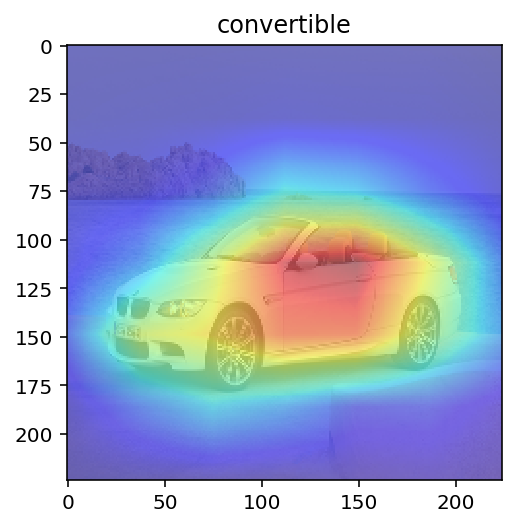

In [3]:
from ResNet_CAM import plot_ResNet_CAM

# img_path = 'images/dog.png'

img_dir = 'images'
img_path = os.path.join(img_dir, 'bmw.png')
fig, ax = plt.subplots()
CAM = plot_ResNet_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
plt.show()

In [40]:
from keras.models import Model
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img, img_to_array


# model = Model(inputs = base_model.inputs, outputs = base_model.get_layer('fc2').output)
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [73]:

base_dir = os.path.join('all', 'train')
img_path = os.path.join(base_dir, 'dog.7022.jpg')

img_dir = 'images'
img_path = os.path.join(img_dir, 'bmw.png')


img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [74]:
preds = model.predict(x)
preds.shape

(1, 1000)

In [75]:
preds = decode_predictions(preds, top=5)
print(preds)

for i, (imagenetID, label, prob) in enumerate(preds[0]):
    print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

[[('n03100240', 'convertible', 0.98093694), ('n04285008', 'sports_car', 0.006336153), ('n02974003', 'car_wheel', 0.0043149306), ('n02704792', 'amphibian', 0.0018762295), ('n02814533', 'beach_wagon', 0.0018090544)]]
1. convertible: 98.09%
2. sports_car: 0.63%
3. car_wheel: 0.43%
4. amphibian: 0.19%
5. beach_wagon: 0.18%


In [76]:
np.argmax(preds[0])

4

In [77]:
from keras import backend as K

predicted_class = np.argmax(preds[0])
output = model.output[:, predicted_class]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap.shape

(14, 14)

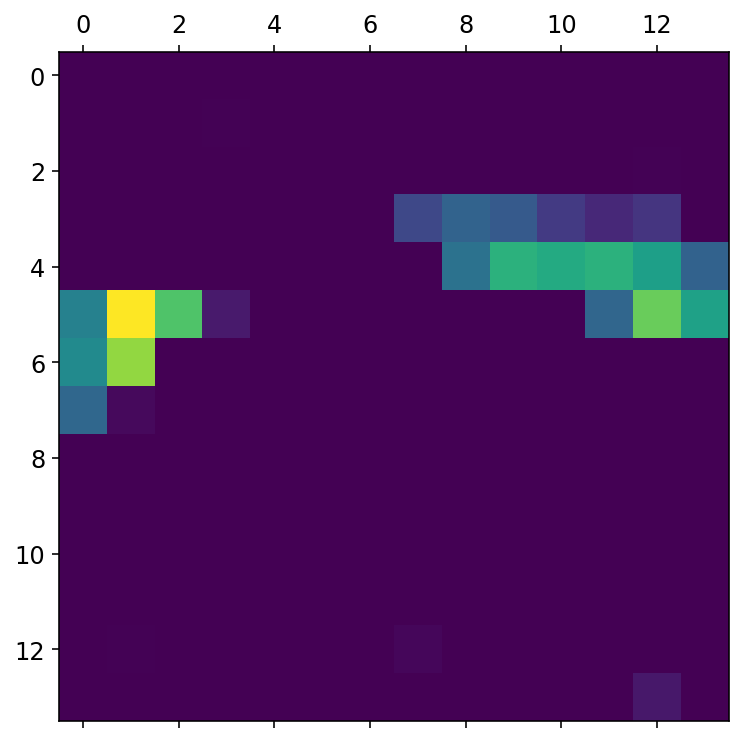

In [78]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [79]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('bmw_cam.jpg', superimposed_img)

True

## Shap

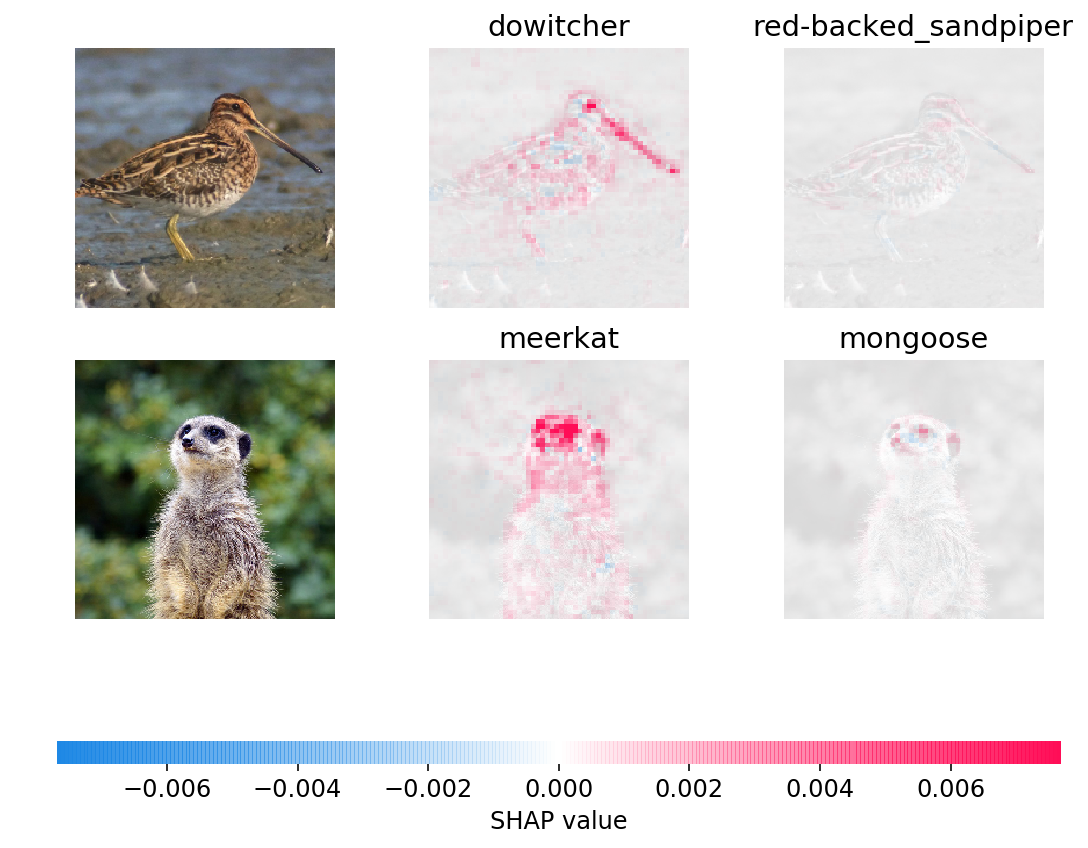

In [53]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

## Reference

- [Keras Documentation: Keras Application](https://keras.io/applications/)
- [Blog: Neural Network Architectures](https://culurciello.github.io/tech/2016/06/04/nets.html)
- [Blog: One by One [1 x 1] Convolution - counter-intuitively useful](http://iamaaditya.github.io/2016/03/one-by-one-convolution/)
- [StackExchange: What does 1x1 convolution mean in a neural network?](http://stats.stackexchange.com/questions/194142/what-does-1x1-convolution-mean-in-a-neural-network)